# Apply 2D layout / embedding methods from scikit-network


[`sknetwork.embedding`](https://scikit-network.readthedocs.io/en/latest/reference/embedding.html) supports several methods that default to creating a two dimensional layout. This notebook applies each method with default hyperparameters.

None of the methods produce diagrams with distinct visual clusters and are therefore not ideal for 2D plots of all genes.

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse
import seaborn
import sknetwork as skn

from utils import get_protein_info_df

## read the STRING combined score network

In [2]:
score_spmatrix = scipy.sparse.load_npz("data/score-matrices/combined_score.sparse.npz")
score_spmatrix = score_spmatrix / 1000 # convert scores to be 0-1
score_spmatrix

<19566x19566 sparse matrix of type '<class 'numpy.float64'>'
	with 11759454 stored elements in Compressed Sparse Row format>

In [3]:
protein_df = get_protein_info_df()
# add degree column
protein_df["degree"] = (score_spmatrix > 0).sum(axis=1)
protein_df.head(2)

,index,protein_external_id,preferred_name,protein_size,annotation,degree
0,0,9606.ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...,1662
1,1,9606.ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...,536


## Configure embedding methods

In [4]:
# https://scikit-network.readthedocs.io/en/latest/reference/embedding.html#
n_components = 2
methods = [
    dict(
        model=skn.embedding.Spectral,
        kwargs=dict(n_components=n_components),
    ),
    dict(
        model=skn.embedding.SVD,
        kwargs=dict(n_components=n_components),
    ),
    dict(
        model=skn.embedding.GSVD,
        kwargs=dict(n_components=n_components),
    ),
    dict(
        model=skn.embedding.Spring,
        kwargs=dict(position_init="spectral"),
    ),
]

### run all embedding methods

In [5]:
embedding_dfs = [protein_df[["index", "preferred_name", "degree"]]]
for method in methods:
    method["name"] = method["model"].__name__.lower()
    np.random.seed(0)  # set random seed for deterministic embeddings
    model = method["model"](**method.get("kwargs", {}))
    embedding = model.fit_transform(adjacency=score_spmatrix)
    method["modularity"], method["fit"], method["diversity"] = skn.embedding.cosine_modularity(
        adjacency=score_spmatrix, embedding=embedding, return_all=True)
    df = pd.DataFrame(embedding, columns=range(1, n_components+1)).add_prefix(f"{method['name']}_")
    embedding_dfs.append(df)

#### performance metrics based on [cosine_modularity](https://scikit-network.readthedocs.io/en/latest/reference/embedding.html#sknetwork.embedding.cosine_modularity)

In [6]:
method_df = pd.DataFrame(methods)
method_df

,model,kwargs,name,modularity,fit,diversity
0,<class 'sknetwork.embedding.spectral.Spectral'>,{'n_components': 2},spectral,0.845240,0.508078,0.337163
1,<class 'sknetwork.embedding.svd.SVD'>,{'n_components': 2},svd,16.383498,6.816678,9.566820
2,<class 'sknetwork.embedding.svd.GSVD'>,{'n_components': 2},gsvd,1.386060,0.952607,0.433453
3,<class 'sknetwork.embedding.spring.Spring'>,{'position_init': 'spectral'},spring,0.937063,0.500000,0.437063


#### visualizing embeddings

In [7]:
embedding_df = pd.concat(embedding_dfs, axis="columns", verify_integrity=True)
embedding_df.head(2)

,index,preferred_name,degree,spectral_1,spectral_2,svd_1,svd_2,gsvd_1,gsvd_2,spring_1,spring_2
0,0,ARF5,1662,-0.007849,-0.999969,3.930347,1.265883,0.999363,-0.035675,4.333704e-07,-0.000042
1,1,M6PR,536,-0.597126,-0.802147,2.459808,1.294378,0.998241,0.059279,-9.862415e-05,-0.000134


In [8]:
# save as a TSV
embedding_df.to_csv("data/embeddings/sknetwork-methods-2d.tsv.xz", sep="\t", index=False, float_format="%.5g")

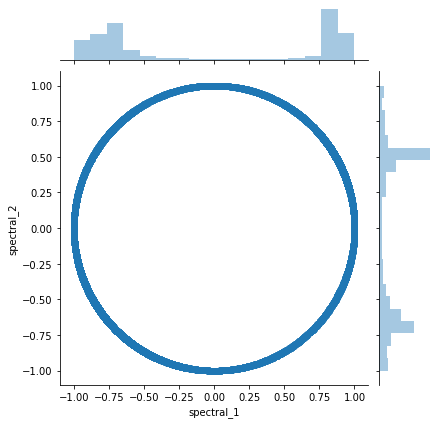

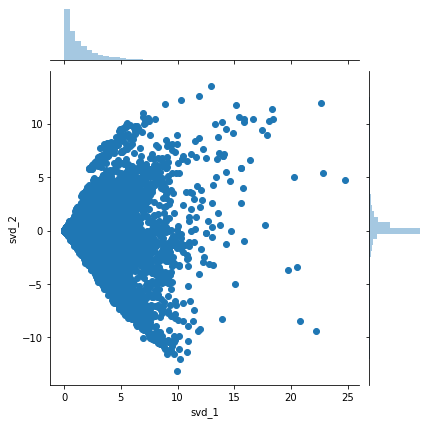

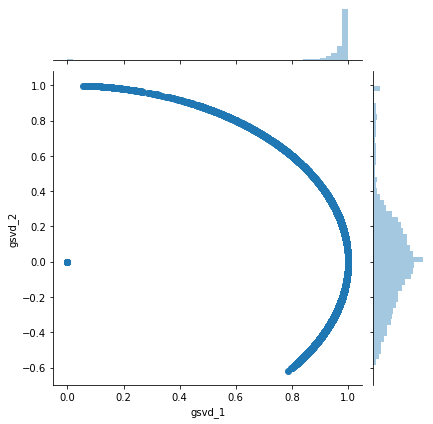

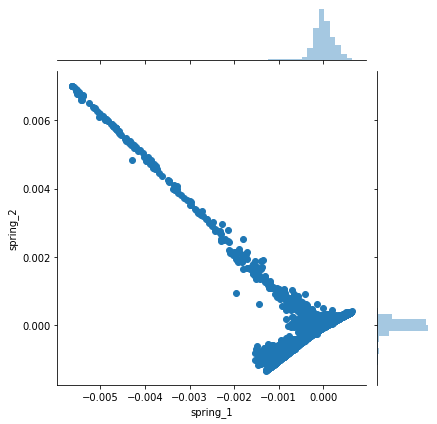

In [9]:
for method in methods:
    name = method["name"]
    seaborn.jointplot(x=f"{name}_1", y=f"{name}_2", data=embedding_df)